## BIF algorithm

<img src="./SGLD_algo.png" width="800" height="800"/>

SGLD optimizer updates parameters like this:
$$\Delta w_t = \frac{\epsilon}{2}\left(\frac{\beta n}{m} \sum_{i=1}^m \nabla \log p\left(y_{l_i} \mid x_{l_i}, w_t\right)+\gamma\left(w_0-w_t\right) - \lambda w_t\right) + N(0, \epsilon\sigma^2)$$

In [1]:
from typing import Callable, Dict, List, Literal, Optional, Type, Union
from devinterp.utils import (
    EvaluateFn,
    EvalResults,
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import os
import copy

from BIF_sampler import (
    BIFEstimator,
    estimate_bif
)

DEVICE = "cuda"

## Generating synthetic data (unit ball in $[-2,2]^2$) and training simple neural network on it

In [2]:
class NeuralNet(nn.Module):
    def __init__(self, non_linear_activation=nn.ReLU(), input_dim=2, output_dim=2):
        super().__init__()
        self.non_linear_activation = non_linear_activation

        self.f = nn.Sequential(
            nn.Linear(input_dim, 10),
            self.non_linear_activation,
            nn.Linear(10, output_dim)
        )

    def forward(self, x):
        return self.f(x)

In [3]:
def gen_synthetic_data(N=50):
    xs=ys=-2
    xe=ye=2
    
    X1 = np.linspace(xs,xe,N)
    X2 = np.linspace(ys,ye,N)
    
    X = np.meshgrid(X1,X2)
    X = np.stack([x.ravel()[:None] for x in X], axis=-1)
    
    Y = ((np.square(X[:,0]) + np.square(X[:,1])) <= 1).astype("int")

    return torch.from_numpy(X).float(), torch.from_numpy(Y)

In [4]:
def train(N=40):
    data,labels=gen_synthetic_data(N=N)
    data = data.to(DEVICE)
    labels = labels.to(DEVICE)

    net = NeuralNet().to(DEVICE)
    # loss_fn = nn.NLLLoss()
    loss_fn = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(net.parameters())

    EPOCHS = 30
    BATCH = 50

    ls = []

    for epoch in range(EPOCHS):
        eloss = 0
        for b in range(100):
            indexes = torch.randperm(data.shape[0])[:BATCH]
            batch = data[indexes]
            target = labels[indexes]
            
            out = net(batch)
            loss = loss_fn(out, target)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

            eloss += loss.item()

        tloss = eloss / data.shape[0]
        ls.append(tloss)

    return data,labels,net,ls

## Train Neural Network (net) and get training data (data), training labels (labels), and losses (ls) 

In [5]:
data,labels,net,ls = train(N=35)

## Sanity check -- viewing epoch vs. loss, training data, neural network performance, and validation data

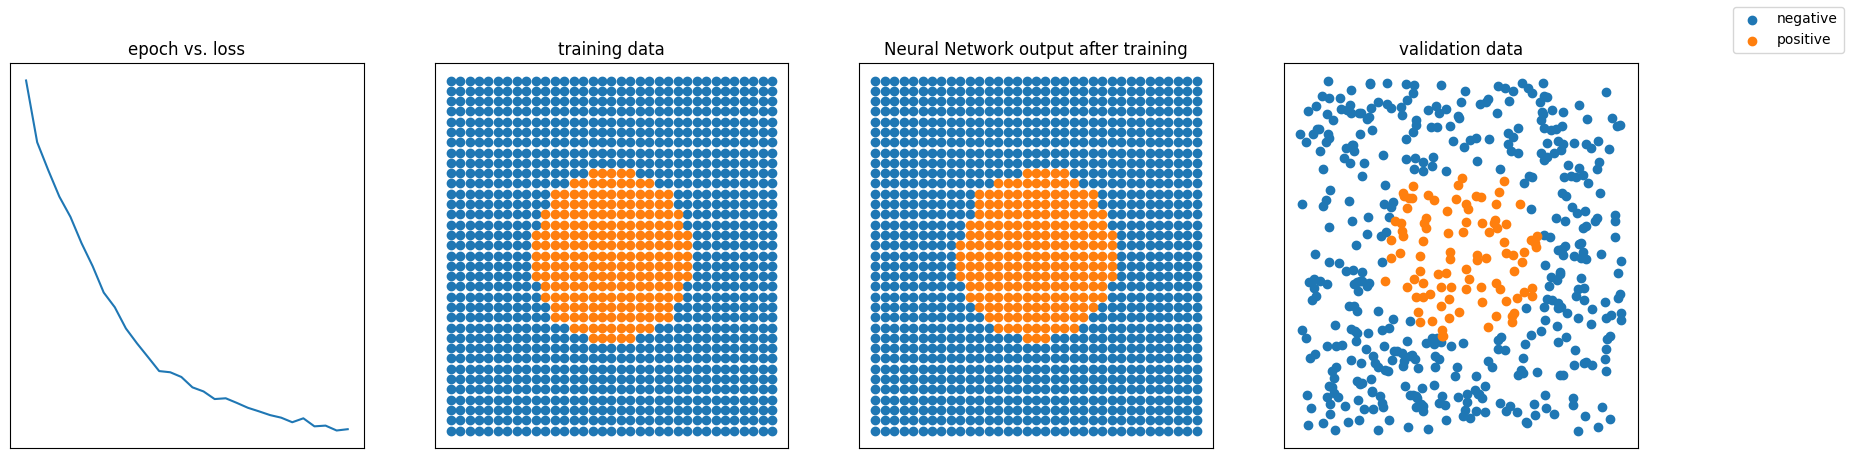

In [6]:
output=None
with torch.no_grad():
    output = torch.argmax(net(data), dim=-1).cpu().numpy()
X = data.cpu().numpy()

valid_data = ((torch.rand((500,2)) - 0.5) * 4).to(DEVICE)
output_valid=None
with torch.no_grad():
    output_valid = torch.argmax(net(valid_data), dim=-1).cpu().numpy()

fig,arr = plt.subplots(1,4,figsize=(21,5))

for a in arr:
    a.set_xticks([])
    a.set_yticks([])

arr[0].plot(np.arange(len(ls)),ls)
arr[0].set_title("epoch vs. loss")

for i in range(2):
    ind_i = labels.cpu() == i
    arr[1].scatter(X[ind_i,0], X[ind_i,1], label="positive" if i > 0 else "negative")
    arr[1].set_title("training data")

fig.legend()

for i in range(2):
    ind_i = output == i
    arr[2].scatter(X[ind_i,0], X[ind_i,1], label=i)
    arr[2].set_title("Neural Network output after training")

for i in range(2):
    ind_i = output_valid == i
    arr[3].scatter(valid_data[ind_i,0].cpu(), valid_data[ind_i,1].cpu(), label=i)
    arr[3].set_title("validation data")

plt.show()

## Bayesian Influence Function 
### main code is in BIF_sampler.py + devinterp 

### Given some chosen point $TESTX \in [-2,2]^2$, the folowing code calculates the influence of every other training point on $\phi(\theta) = CrossEntropy(TESTX, \theta)$, where $\theta$ are the parameters of the Neural Network.

In [11]:
TESTX = (1.5,1.5)
def make_test_pt_torch(point, device="cpu"):
    x1,x2=point
    norm = np.square(x1) + np.square(x2)
    lab = 1 if norm <= 1 else 0
    return (torch.tensor([x1,x2]).float().to(device), torch.tensor(lab).to(device))

def evaluate_function(model: nn.Module, data: torch.Tensor, device="cpu") -> EvalResults:
    """
    model (torch.nn.module): model used for Bayesian Influence Function 
    data (torch.Tensor): minibatch data used to update weights of model in SGLD
    device (String): either "cuda" or "cpu"

    returns:
    dictionary with 
    (i) loss - loss used to update weights of model
    (ii) obs - calculated observables (in this case CrossEntropy(TESTX, theta) as described above
    (iii) loss_vec - the losses evaluated at every training point for the model used to compute the BIF as described in the algorithm at the top
    """
    inputs, outputs = data
    x,y = make_test_pt_torch(TESTX, device=device)
    train_data, train_labels = gen_synthetic_data(N=35)
    train_data = train_data.to(device)
    train_labels = train_labels.to(device)

    return {
        "loss": torch.nn.functional.cross_entropy(model(inputs), outputs),
        "obs": torch.tensor(torch.nn.functional.cross_entropy(model(x), y).item()),
        "loss_vec": torch.nn.functional.cross_entropy(model(train_data), train_labels, reduction="none")
    }

loader = torch.utils.data.DataLoader(list(zip(data,labels)), shuffle=False, batch_size=6)

In [12]:
test = estimate_bif(
    model=copy.deepcopy(net),
    loader = loader,
    evaluate = evaluate_function,
    num_obs=1,
    device="cpu",
    num_chains=6,
    num_draws=400,
    num_data=data.shape[0]
)

Chain 5: 100%|██████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 1088.54it/s]


In [13]:
BIF = -test["BIF"]
# print(test["obs/trace"])

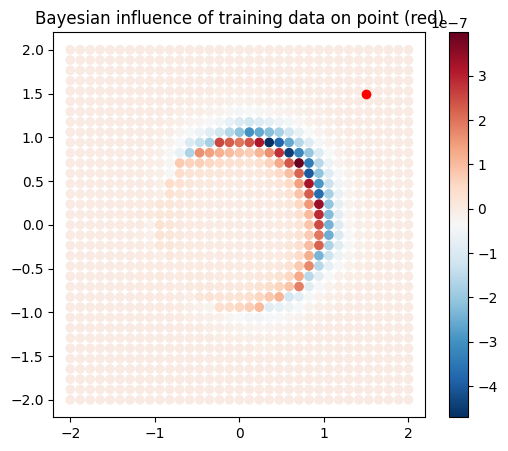

In [14]:
X = data.cpu().numpy()
fig, arr = plt.subplots(1,1,figsize=(6,5))
scatter = arr.scatter(X[:,0], X[:,1], c=BIF[:,0], cmap=cm.RdBu_r)
arr.scatter(TESTX[0], TESTX[1], c="red")
fig.colorbar(scatter)
plt.title("Bayesian influence of training data on point (red)")
plt.show()